In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [3]:
from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.tasks import Task

from lightautoml.addons.interpretation import LimeTextExplainer

C:\Users\Admin\.conda\envs\oldervenv\Lib\site-packages\lightautoml\transformers\text.py:22: UserWarning: 'gensim' - package isn't installed
  warnings.warn("'gensim' - package isn't installed")
C:\Users\Admin\.conda\envs\oldervenv\Lib\site-packages\lightautoml\addons\interpretation\l2x.py:23: UserWarning: 'gensim' - package isn't installed
  warnings.warn("'gensim' - package isn't installed")


In [4]:
import torch

In [5]:
torch.cuda.is_available()

True

In [6]:
from transformers import logging

logging.set_verbosity_error()

In [7]:
np.random.seed(42)

In [8]:
reviews = pd.read_csv('data/reviews.csv.zip', sep='\t')
reviews.drop_duplicates(subset=['review'], inplace=True)
reviews.sample(10)

,review,sentiment
45140,"Ехала долго посылка, больше полутора месяца. Д...",neautral
82647,Очень красивый и приятный на ощупь)),positive
39454,"нитки торчат, прошито очень неаккуратно",neautral
71219,Доставка быстрая. По размеру подошло 46 р-р. Т...,positive
45132,Пахнет,neautral
72801,"Отлично всё - пошив, качество, фасон. Брала сп...",positive
67107,"Пришли за три недели, на 39 идеально!!! Понрав...",positive
1487,Плохое качество и велик размер S. Хотя у меня ...,negative
9131,Прошло 4 месяца с продом.продлевали защиту тов...,negative
3752,Товар так и не пришел! Пришел подарок от продо...,negative


In [9]:
full_counts = reviews.groupby('sentiment').agg(count = ('sentiment', 'count'))
full_counts

,count
sentiment,
neautral,28812
negative,29218
positive,29291


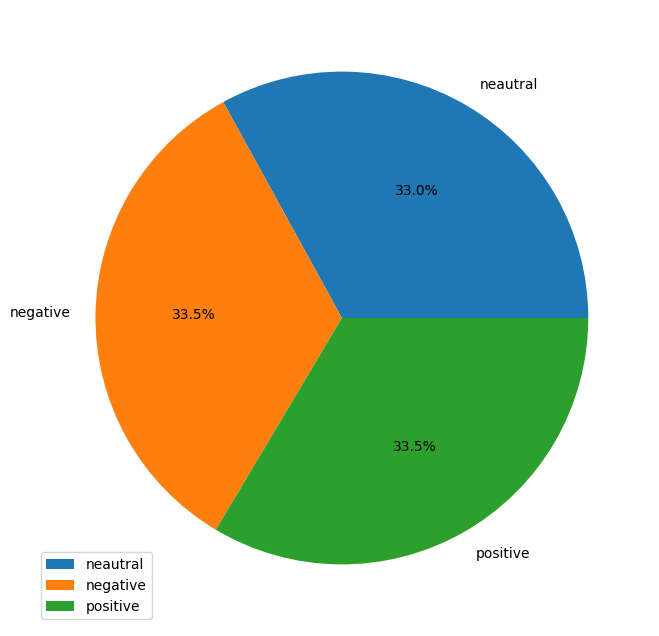

In [10]:
full_counts.plot.pie(figsize=(8, 8), subplots=True, autopct='%1.1f%%')
plt.ylabel('')
plt.legend(loc='lower left')
plt.show()

In [11]:
sentiment_map = {
    'negative': 0,
    'neautral': 1,
    'positive': 2
}

In [12]:
reviews.sentiment = reviews.sentiment.apply(lambda x: sentiment_map[x])
reviews.sample(10)

,review,sentiment
71368,"Очень высокая талия и тугая резинка, в остальн...",2
83060,супер как всегда,2
44341,"в описании указан хлопок, на этикетке 65%полиэ...",1
11706,Не получил . Вёл спор спор закрыли с возвратом...,0
45829,не дошёл. видимо наша почта. было два заказа о...,1
5373,"Толстовка пришла примерно за 1,5 месяца до Арх...",0
54297,"Пижама пришла с дырками, а так качество хороше...",1
31163,"выбрала не тот размер - s, так как рукава нач...",1
62551,"Прислали не тот цвет. Заказывала серый, а прис...",2
48628,"Размер маленький, заказала м, пришла хl",1


In [13]:
train, test = train_test_split(reviews, test_size=0.2, random_state=42)

In [14]:
task = Task('multiclass', loss='f1')

In [15]:
automl = TabularNLPAutoML(
    task=task,
    gpu_ids='0',
    general_params={
        'nested_cv': False,
        'use_algos': [['nn', 'linear_l2', 'lgb']]
    },
    text_params={
        'lang': 'ru'
    },
    timeout=3600,
    cpu_limit=4,
    reader_params={
        'random_state': 42
    },
    nn_params={
        'opt_params': {'lr': 1e-5},
        'max_length': 128,
        'bs': 32,
        'n_epochs': 7,
    }
)

In [16]:
roles = {
    'text': ['review'],
    'target': 'sentiment'
}

In [17]:
%%time
oof_predict = automl.fit_predict(train, roles=roles, verbose=5)

[12:35:58] Stdout logging level is DEBUG.
[12:35:58] Model language mode: ru
[12:35:58] Task: multiclass

[12:35:58] Start automl preset with listed constraints:
[12:35:58] - time: 3600.00 seconds
[12:35:58] - CPU: 4 cores
[12:35:58] - memory: 16 GB

[12:35:58] Train data shape: (69856, 2)

[12:35:58] Layer 1 train process start. Time left 3599.96 secs
[12:36:10] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:36:10] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 100}
[12:36:10] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[12:36:12] Linear model: C = 1e-05 score = -1.1005894053559164
[12:36:13] Linear model: C = 5e-05 score = -1.1005894053559164
[12:36:13] Linear model: C = 0.0001 score = -1.1005894053559164
[12:36:13] ===== Start working with fold 1 f

  0%|                                                                                          | 0/219 [00:00<?, ?it/s]C:\Users\Admin\.conda\envs\oldervenv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [10:02<00:00,  2.75s/it]


[12:46:22] Feature concated__review transformed
[12:46:23] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:46:23] Training params: {'task': 'train', 'learning_rate': 0.03, 'num_leaves': 64, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 4, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 1200, 'early_stopping_rounds': 200, 'random_state': 42}
[12:46:23] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[12:46:28] Training until validation scores don't improve for 200 rounds
[12:47:10] [100]	valid's multi_logloss: 0.000931622
[12:47:52] [200]	valid's multi_logloss: -1.32558
[12:48:16] [300]	valid's multi_logloss: -1.87358
[12:48:25] [400]	valid's multi_logloss: -2.21284
[12:48:31] [500]	valid's multi_logloss: -2.46601
[12:48:37] [600]	valid's multi_logloss: -2.6714
[12:48:42] [700]	valid's multi_logloss: -2.838

C:\Users\Admin\.conda\envs\oldervenv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[13:09:03] Epoch: 0, train loss: -0.5600939393043518, val loss: -0.5802683234214783, val metric: -0.5708573700281828
[13:22:44] Epoch: 1, train loss: -0.5782846808433533, val loss: -0.5825074315071106, val metric: -0.575445364816219
[13:36:50] Epoch: 2, train loss: -0.5920115113258362, val loss: -0.5812731981277466, val metric: -0.5949136811340022
[13:36:53] Time limit exceeded after calculating fold 0

[13:36:53] Fitting Lvl_0_Pipe_2_Mod_0_TorchNN__linear_layer_0 finished. score = -0.5949136811340022
[13:36:53] Lvl_0_Pipe_2_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed
[13:36:53] Time left -55.41 secs

[13:36:53] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.

[13:36:53] Layer 1 training completed.

[13:36:53] Blending: optimization starts with equal weights and score -0.7805581364508196
[13:36:53] Blending: iteration 0: score = -0.7118186606904026, weights = [0.05511818 0.18094979 0.76393205]
[13:36:54] Blending: iteration

In [18]:
%%time
test_pred = automl.predict(test)
test_pred

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [02:42<00:00,  2.95s/it]


[13:39:44] Feature concated__review transformed
[13:39:56] Last linear layer not founded, so init_bias=False


C:\Users\Admin\.conda\envs\oldervenv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


array([[0.10684817, 0.8097664 , 0.08338545],
       [0.07052832, 0.08103839, 0.84843326],
       [0.25625676, 0.65766203, 0.08608122],
       ...,
       [0.2176136 , 0.6060892 , 0.17629725],
       [0.7403015 , 0.15933894, 0.1003596 ],
       [0.19385871, 0.71585095, 0.09029038]], dtype=float32)

In [19]:
predictied_labels = np.argmax(test_pred.data, axis=1)
predictied_labels

array([1, 2, 1, ..., 1, 0, 1], dtype=int64)

In [20]:
accuracy_score(predictied_labels, test['sentiment'])

0.7765244775264816

In [21]:
f1_score(test['sentiment'], predictied_labels, average='macro')

0.7785341403489191

In [22]:
lime = LimeTextExplainer(automl, feature_selection='lasso', force_order=False)

In [23]:
exp = lime.explain_instance(test.iloc[42], labels=(0, 1, 2), perturb_column='review')
exp.visualize_in_notebook(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:58<00:00,  3.68s/it]


[13:42:32] Feature concated__review transformed
[13:42:37] Last linear layer not founded, so init_bias=False


C:\Users\Admin\.conda\envs\oldervenv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Text
 
 
 куртка отличная , цвет глубокий , насыщенный . в 5 градусов уже хочется одеть кофточку под низ . брала чтобы ездить с ней по лесам , ну и так , в городе за хлебом сбегать - эти потребности полностью удовлетворены ) нитки и пушинки особо не торчат, запаха нет. качество хорошее, но хотелось бы немного потеплее. на постоянной 168, ог 87, об 89 взяла размер м, что хорошо - выглядит аккуратно, можно пододеть что то. думаю размер s был бы тоже норм, но без опции утепления неторчат запаха нет качество хорошее но хотелось бы немного потеплее на постоянной ог об взяла размер что хорошо выглядит аккуратно можно пододеть что то думаю размер был бы тоже норм но без опции утепления 
 
 
 
 Class mapping
 
 
 
 
 Other classes
 
 Class: 1
 
 
 

 
 -3.1 -2.5 -1.8 -1.2 -0.6 0.0 0.6 1.2 1.8 2.5 3.1

In [24]:
predictied_labels[42]

2

In [25]:
test.iloc[42]

review       куртка отличная, цвет глубокий, насыщенный. в ...
sentiment                                                    2
Name: 79206, dtype: object

## Сохранение модели

In [26]:
import pickle

with open('models/small_text_lama_classifier.pkl', 'wb') as f:
    pickle.dump(automl, f)

## Загрузка и повторное тестирование модели

In [27]:
with open('models/small_text_lama_classifier.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)

In [28]:
%%time
test_pred = automl.predict(test)
test_pred

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [02:42<00:00,  2.96s/it]


[14:00:52] Feature concated__review transformed
[14:01:06] Last linear layer not founded, so init_bias=False


C:\Users\Admin\.conda\envs\oldervenv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


CPU times: total: 4min 32s
Wall time: 4min 35s


array([[0.10684817, 0.8097664 , 0.08338545],
       [0.07052832, 0.08103839, 0.84843326],
       [0.25625676, 0.65766203, 0.08608122],
       ...,
       [0.2176136 , 0.6060892 , 0.17629725],
       [0.7403015 , 0.15933894, 0.1003596 ],
       [0.19385871, 0.71585095, 0.09029038]], dtype=float32)

In [29]:
predictied_labels = np.argmax(test_pred.data, axis=1)
predictied_labels

array([1, 2, 1, ..., 1, 0, 1], dtype=int64)

In [30]:
accuracy_score(predictied_labels, test['sentiment'])

0.7765244775264816

In [31]:
f1_score(test['sentiment'], predictied_labels, average='macro')

0.7785341403489191